# Análise exploratória

In [ ]:
import csv
import sys
import pandas
import sqlalchemy
import sqlalchemy.orm as orm
import os
import json
import re
import html
import unicodedata
import ast
from dotenv import load_dotenv
from datetime import datetime
from sqlalchemy import func, case
import matplotlib.pyplot as plt

## Conectar com o banco de dados

O procedimento para conectar com o banco de dados segue o mesmo apresentado no arquivo `02-preprocessamento.ipynb`.

### Variáveis de ambiente e motor de conexão

In [26]:
# Carregar variáveis de ambiente
load_dotenv()
POSTGRES_HOST = os.getenv("POSTGRES_HOST")
POSTGRES_PORT = os.getenv("POSTGRES_PORT")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
POSTGRES_DB = os.getenv("POSTGRES_DB")

# Verificar se todas as variáveis foram carregadas
required_vars = {
    "POSTGRES_HOST": POSTGRES_HOST,
    "POSTGRES_PORT": POSTGRES_PORT,
    "POSTGRES_USER": POSTGRES_USER,
    "POSTGRES_PASSWORD": POSTGRES_PASSWORD,
    "POSTGRES_DB": POSTGRES_DB,
}

missing = [k for k, v in required_vars.items() if not v]
if missing:
    raise EnvironmentError(f"Variáveis de ambiente ausentes: {', '.join(missing)}")

# URL de conexão com o banco de dados
DATABASE_URL = (
    f"postgresql+psycopg://{POSTGRES_USER}:{POSTGRES_PASSWORD}"
    f"@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
)

# Criar o motor de conexão com o banco de dados
engine = sqlalchemy.create_engine(DATABASE_URL)

# Testar a conexão com o banco de dados
try:
    with engine.connect() as connection:
        print("✅ Conexão com o banco de dados estabelecida com sucesso!")
except Exception as e:
    print(f"❌ Erro ao conectar ao banco de dados: {e}")

✅ Conexão com o banco de dados estabelecida com sucesso!


### Tabelas de associação

In [27]:
Base = orm.declarative_base()

game_developer = sqlalchemy.Table(
    "game_developer",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("developer_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("developers.id"), primary_key=True)
)

game_publisher = sqlalchemy.Table(
    "game_publisher",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("publisher_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("publishers.id"), primary_key=True)
)

game_category = sqlalchemy.Table(
    "game_category",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("category_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("categories.id"), primary_key=True)
)

game_genre = sqlalchemy.Table(
    "game_genre",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("genre_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("genres.id"), primary_key=True)
)

game_tag = sqlalchemy.Table(
    "game_tag",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("tag_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("tags.id"), primary_key=True)
)

game_language = sqlalchemy.Table(
    "game_language",
    Base.metadata,
    sqlalchemy.Column("game_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), primary_key=True),
    sqlalchemy.Column("language_id", sqlalchemy.Integer, sqlalchemy.ForeignKey("languages.id"), primary_key=True)
)

### Definição dos modelos

In [28]:
class Developer(Base):
    __tablename__ = "developers"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.Text, nullable=False)

    games = orm.relationship("Game", secondary=game_developer, back_populates="developers")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Publisher(Base):
    __tablename__ = "publishers"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.Text, nullable=False)

    games = orm.relationship("Game", secondary=game_publisher, back_populates="publishers")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Category(Base):
    __tablename__ = "categories"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)

    games = orm.relationship("Game", secondary=game_category, back_populates="categories")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Genre(Base):
    __tablename__ = "genres"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)

    games = orm.relationship("Game", secondary=game_genre, back_populates="genres")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Tag(Base):
    __tablename__ = "tags"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)

    games = orm.relationship("Game", secondary=game_tag, back_populates="tags")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Language(Base):
    __tablename__ = "languages"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    name = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)

    games = orm.relationship("Game", secondary=game_language, back_populates="languages")

    @classmethod
    def get_or_create(cls, name, session):
        parsed = name.strip().lower()
        obj = session.query(cls).filter_by(name=parsed).first()
        if obj:
            return obj
        obj = cls(name=parsed)
        session.add(obj)
        session.commit()
        return obj


class Screenshot(Base):
    __tablename__ = "screenshots"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    game_id = sqlalchemy.Column(sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), nullable=False)
    screenshot_url = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)


class Movie(Base):
    __tablename__ = "movies"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    game_id = sqlalchemy.Column(sqlalchemy.Integer, sqlalchemy.ForeignKey("games.id"), nullable=False)
    movie_url = sqlalchemy.Column(sqlalchemy.String(255), nullable=False)


class Game(Base):
    __tablename__ = "games"

    id = sqlalchemy.Column(sqlalchemy.Integer, primary_key=True)
    app_id = sqlalchemy.Column(sqlalchemy.Integer, nullable=False)
    name = sqlalchemy.Column(sqlalchemy.Text, nullable=False)
    release_date = sqlalchemy.Column(sqlalchemy.Date, nullable=False)
    estimated_owners_lower = sqlalchemy.Column(sqlalchemy.Integer, nullable=False)
    estimated_owners_upper = sqlalchemy.Column(sqlalchemy.Integer, nullable=False)
    peak_ccu = sqlalchemy.Column(sqlalchemy.Integer, nullable=False, default=0)
    required_age = sqlalchemy.Column(sqlalchemy.Integer, nullable=False, default=0)
    price = sqlalchemy.Column(sqlalchemy.Float, nullable=False, default=0.0)
    discount = sqlalchemy.Column(sqlalchemy.Float, nullable=False, default=0.0)
    dlc_count = sqlalchemy.Column(sqlalchemy.Integer, nullable=False, default=0)
    about_the_game = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    header_image = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    website = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    support_url = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    support_email = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    windows = sqlalchemy.Column(sqlalchemy.Boolean, nullable=False, default=False)
    mac = sqlalchemy.Column(sqlalchemy.Boolean, nullable=False, default=False)
    linux = sqlalchemy.Column(sqlalchemy.Boolean, nullable=False, default=False)
    metacritic_score = sqlalchemy.Column(sqlalchemy.Float, nullable=True)
    metacritic_url = sqlalchemy.Column(sqlalchemy.Text, nullable=True)
    user_score = sqlalchemy.Column(sqlalchemy.Float, nullable=True)
    positive = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    negative = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    score_rank = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    achievements = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    recommendations = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    average_playtime_forever = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    average_playtime_2weeks = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    median_playtime_forever = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)
    median_playtime_2weeks = sqlalchemy.Column(sqlalchemy.Integer, nullable=True)

    # RELACIONAMENTOS M:N
    developers = orm.relationship("Developer", secondary=game_developer, back_populates="games")
    publishers = orm.relationship("Publisher", secondary=game_publisher, back_populates="games")
    categories = orm.relationship("Category", secondary=game_category, back_populates="games")
    genres = orm.relationship("Genre", secondary=game_genre, back_populates="games")
    tags = orm.relationship("Tag", secondary=game_tag, back_populates="games")
    languages = orm.relationship("Language", secondary=game_language, back_populates="games")


### Sessão para comunicação com banco

In [29]:
session = sqlalchemy.orm.Session(engine)

### Funções utilitárias

In [30]:
def format_number(number):
    """
    Formata um número para ser exibido com separadores de milhares
    Ex: 1000000 -> 1.000.000
    Ex: 1000000000 -> 1.000.000.000
    Ex: 123456.789 -> 123.456,789
    """
    # Converte para string para tratar parte inteira e decimal
    number_str = str(number)

    if "." in number_str:
        integer_part, decimal_part = number_str.split(".")
    else:
        integer_part = number_str
        decimal_part = None

    # Formata a parte inteira com separadores de milhar
    integer_part = "{:,}".format(int(integer_part)).replace(",", ".")

    # Junta novamente com a parte decimal, se existir
    if decimal_part is not None:
        return f"{integer_part},{decimal_part}"

    return integer_part

## Análise de Jogos

### Grátis vs Pagos

A grande maioria dos jogos na Steam são pagos, mas há uma quantidade significativa de jogos gratuitos.

Jogos gratuitos: 23247
Jogos pagos: 88205
Total de jogos: 111452


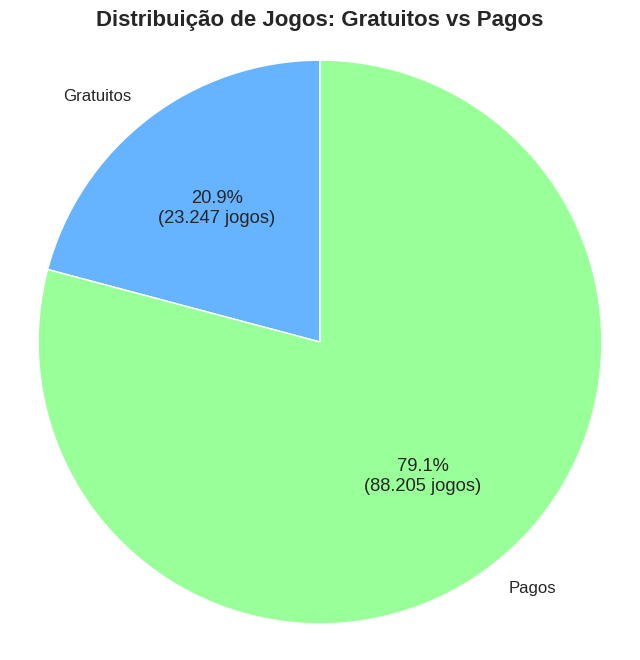

In [61]:
# Query
result = session.query(
    func.sum(case((Game.price == 0, 1), else_=0)).label("free_games"),
    func.sum(case((Game.price > 0, 1), else_=0)).label("paid_games"),
).first()

free_games, paid_games = result
total_games = free_games + paid_games

print(f"Jogos gratuitos: {free_games}")
print(f"Jogos pagos: {paid_games}")
print(f"Total de jogos: {total_games}")

# Função para mostrar porcentagem + quantidade
def autopct_format(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({format_number(count)} jogos)"

    return my_autopct


# Criar gráfico de pizza
labels = ["Gratuitos", "Pagos"]
sizes = [free_games, paid_games]
colors = ["#66b3ff", "#99ff99"]

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=autopct_format(sizes),
    startangle=90,
)
plt.title(
    "Distribuição de Jogos: Gratuitos vs Pagos",
    fontsize=16,
    fontweight="bold",
)
plt.axis("equal")
plt.show()

### Preço

A Steam possui uma grande variedade de jogos pagos, com preços que variam bastante. Abaixo está um resumo estatístico dos preços dos jogos pagos, considerando apenas títulos com preço maior que zero.

In [39]:
session.rollback()

In [41]:
minimal_price = session.query(func.min(Game.price)).filter(Game.price > 0).scalar()
maximal_price = session.query(func.max(Game.price)).filter(Game.price > 0).scalar()
average_price = session.query(func.avg(Game.price)).filter(Game.price > 0).scalar()
median_price = (
    session.query(
        func.percentile_cont(0.5)
        .within_group(Game.price)
    )
    .filter(Game.price > 0)
    .scalar()
)

print(f"Preço mínimo: {minimal_price:.2f}")
print(f"Preço máximo: {maximal_price:.2f}")
print(f"Preço médio: {average_price:.2f}")
print(f"Preço mediano: {median_price:.2f}")



Preço mínimo: 0.29
Preço máximo: 999.98
Preço médio: 8.92
Preço mediano: 5.09


Podemos inferir com os resultados que há uma distribuição assimétrica à direita. A maioria dos jogos custa perto dos 5 dólares, poucos jogos caros puxam a média para cima.

10%: 0.99
25%: 2.99
50%: 5.09
75%: 9.99
90%: 19.99
95%: 24.99
99%: 49.99


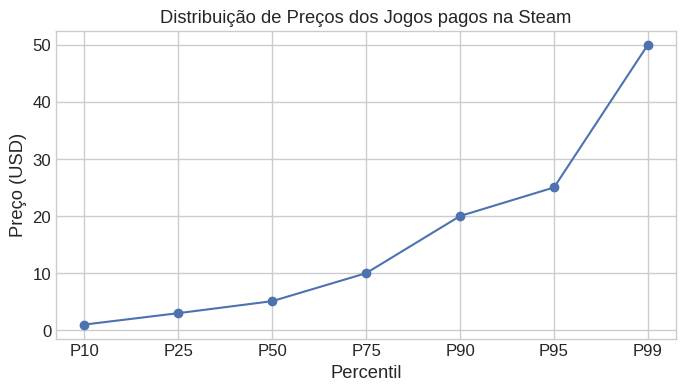

In [51]:
percentiles = (
    session.query(
        func.percentile_cont([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
        .within_group(Game.price)
    )
    .filter(Game.price > 0)
    .scalar()
)

p10, p25, p50, p75, p90, p95, p99 = percentiles

print(f"10%: {p10:.2f}")
print(f"25%: {p25:.2f}")
print(f"50%: {p50:.2f}")
print(f"75%: {p75:.2f}")
print(f"90%: {p90:.2f}")
print(f"95%: {p95:.2f}")
print(f"99%: {p99:.2f}")

labels = ["P10", "P25", "P50", "P75", "P90", "P95", "P99"]
values = [p10, p25, p50, p75, p90, p95, p99]

plt.figure(figsize=(8, 4))
plt.plot(labels, values, marker="o")
plt.title("Distribuição de Preços dos Jogos pagos na Steam")
plt.ylabel("Preço (USD)")
plt.xlabel("Percentil")
plt.grid(True)

plt.show()


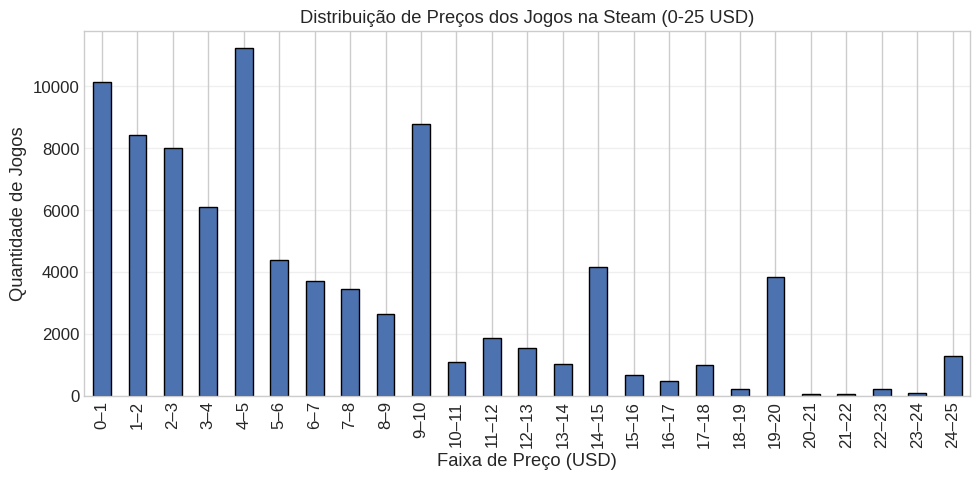

In [60]:
# 1. Carregar dados do banco
df = pandas.read_sql(
    session.query(Game.price)
    .filter(Game.price > 0)
    .statement,
    session.bind,
)

# 2. Definir faixas de preço
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
labels = [
    "0–1", "1–2", "2–3", "3–4",
    "4–5", "5–6", "6–7", "7–8",
    "8–9", "9–10", "10–11", "11–12",
    "12–13", "13–14", "14–15", "15–16",
    "16–17", "17–18", "18–19", "19–20",
    "20–21", "21–22", "22–23", "23–24",
    "24–25"
]

df["price_range"] = pandas.cut(
    df["price"],
    bins=bins,
    labels=labels,
    right=False,
)

# 3. Contar jogos por faixa
counts = df["price_range"].value_counts().sort_index()

# 4. Plotar gráfico
plt.figure(figsize=(10, 5))
counts.plot(kind="bar", edgecolor="black")

plt.title("Distribuição de Preços dos Jogos na Steam (0-25 USD)")
plt.xlabel("Faixa de Preço (USD)")
plt.ylabel("Quantidade de Jogos")

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.show()

A distribuição de preços dos jogos pagos na Steam apresenta forte concentração nas faixas de menor valor, com um picos evidentes entre US$ 4–5, US$ 9-10, US$ 14-15 e US$ 19-20 seguido por frequências elevadas também nas faixas de US$ 0–1, US$ 1–2 e US$ 2–3. Esse padrão confirma a predominância de títulos de baixo custo na plataforma, indicando que a maior parte da oferta está posicionada em valores acessíveis ao consumidor. A presença de múltiplos picos em torno de preços psicológicos (especialmente valores terminados em .99) sugere que as decisões de precificação seguem estratégias de mercado bem estabelecidas, reforçando a hipótese de que o ecossistema da Steam incentiva preços competitivos como forma de maximizar alcance e visibilidade, especialmente para jogos independentes.

Observa-se ainda uma redução progressiva na quantidade de títulos à medida que o preço aumenta, caracterizando uma distribuição assimétrica à direita com cauda longa. Faixas acima de US$ 10 concentram significativamente menos jogos, indicando que preços mais elevados representam um segmento minoritário da oferta total, possivelmente associado a títulos AAA, edições completas ou pacotes de conteúdo. Esse comportamento reforça a noção da Steam como um mercado de alto volume e baixo ticket médio, no qual a mediana e a concentração em faixas inferiores fornecem uma representação mais fiel do preço típico do que métricas baseadas em valores extremos.

/tmp/ipykernel_58955/2046001748.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_owners_by_range = df.groupby('price_range')['avg_owners'].mean().reset_index()


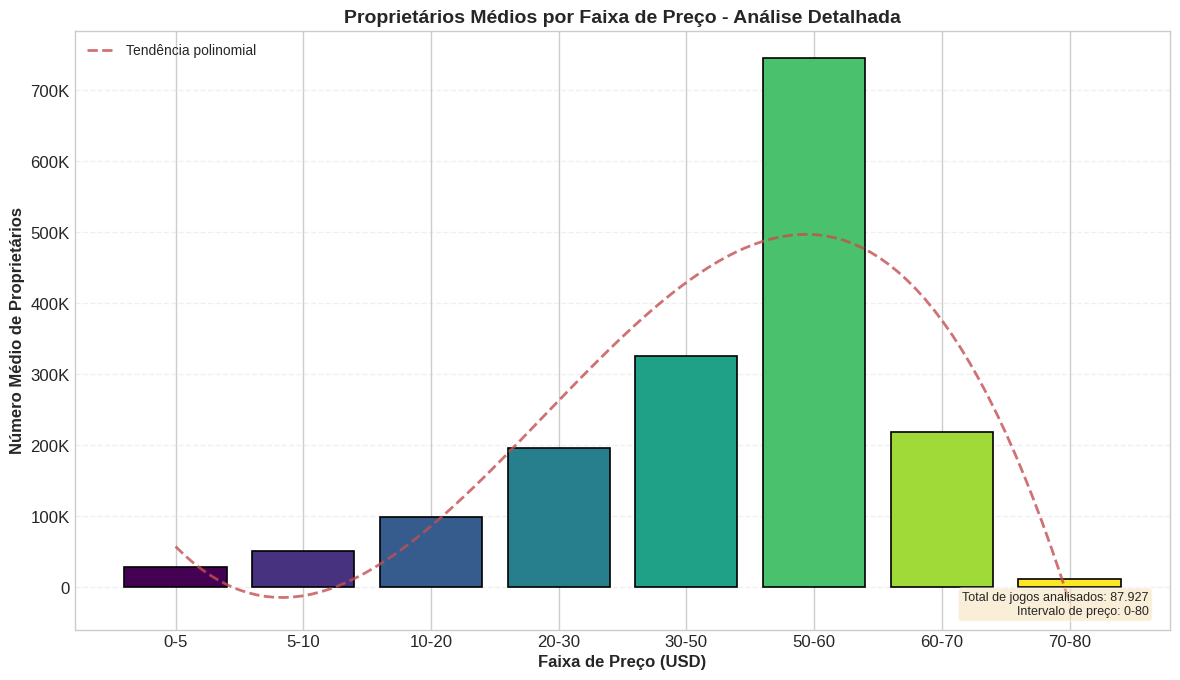


Valores detalhados:
0-5: 28.216 proprietários médios
5-10: 51.471 proprietários médios
10-20: 98.891 proprietários médios
20-30: 195.631 proprietários médios
30-50: 326.341 proprietários médios
50-60: 745.446 proprietários médios
60-70: 218.103 proprietários médios
70-80: 11.774 proprietários médios


In [65]:
import numpy as np

# 1. Carregar dados do banco (preço e proprietários estimados)
df = pandas.read_sql(
    session.query(
        Game.price,
        Game.estimated_owners_lower,
        Game.estimated_owners_upper
    )
    .filter(Game.price <= 80)
    .filter(Game.price > 0)
    .statement,
    session.bind,
)

# 2. Calcular o número médio de proprietários para cada jogo
df['avg_owners'] = (df['estimated_owners_lower'] + df['estimated_owners_upper']) / 2

# 3. Definir faixas de preço
bins = [0, 5, 10, 20, 30, 50, 60, 70, 80]
labels = ["0-5", "5-10", "10-20", "20-30", "30-50", "50-60", "60-70", "70-80"]

df['price_range'] = pandas.cut(
    df['price'],
    bins=bins,
    labels=labels,
    right=False,
)

# 4. Agrupar por faixa de preço e calcular a média de proprietários
avg_owners_by_range = df.groupby('price_range')['avg_owners'].mean().reset_index()
avg_owners_by_range.columns = ['price_range', 'avg_owners']

# 5. Obter informações para o gráfico
total_games = len(df)
price_range_str = f"0-80"

# 6. Criar o gráfico
fig, ax = plt.subplots(figsize=(12, 7))

# Preparar dados para o gráfico
x_labels = avg_owners_by_range['price_range'].astype(str).tolist()
y_values = avg_owners_by_range['avg_owners'].tolist()

# Criar gradiente de cores (de roxo/azul para verde/amarelo)
colors = plt.cm.viridis(np.linspace(0, 1, len(x_labels)))

# Criar gráfico de barras
bars = ax.bar(x_labels, y_values, color=colors, edgecolor='black', linewidth=1.2)

# 7. Adicionar linha de tendência polinomial
x_numeric = np.arange(len(x_labels))
# Ajustar polinômio de grau 3
z = np.polyfit(x_numeric, y_values, 3)
p = np.poly1d(z)
x_trend = np.linspace(0, len(x_labels) - 1, 100)
y_trend = p(x_trend)

ax.plot(x_trend, y_trend, 'r--', linewidth=2, label='Tendência polinomial', alpha=0.8)

# 8. Configurar o gráfico
ax.set_xlabel('Faixa de Preço (USD)', fontsize=12, fontweight='bold')
ax.set_ylabel('Número Médio de Proprietários', fontsize=12, fontweight='bold')
ax.set_title('Proprietários Médios por Faixa de Preço - Análise Detalhada', fontsize=14, fontweight='bold')

# Formatar eixo Y para mostrar valores em K (milhares)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x >= 1000 else f'{int(x)}'))

# Adicionar grid
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adicionar legenda
ax.legend(loc='upper left', fontsize=10)

# Adicionar informações no canto inferior direito
info_text = f'Total de jogos analisados: {format_number(total_games)}\nIntervalo de preço: {price_range_str}'
ax.text(0.98, 0.02, info_text, transform=ax.transAxes, 
        fontsize=9, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Mostrar valores exatos
print("\nValores detalhados:")
for _, row in avg_owners_by_range.iterrows():
    print(f"{row['price_range']}: {format_number(int(row['avg_owners']))} proprietários médios")